In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math

In [3]:
df = pd.read_pickle(r"C:\Users\Almog\Desktop\Data Science\Projects\Bank Customer Churn\Pickle files\FS_BCC.pkl")
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,inactive_long_tenure,single_product,multi_product,active_single_product,has_balance,high_balance,salary_to_balance_ratio,young_customer,senior_customer,senior_inactive
0,619,1,2,42,2,0.00,1,1,1,101348.88,...,0,1,0,1,0,0,101348.880000,0,0,0
1,608,3,2,41,1,83807.86,1,0,1,112542.58,...,0,1,0,1,1,0,1.342848,0,0,0
2,502,1,2,42,8,159660.80,3,1,0,113931.57,...,1,0,1,0,1,1,0.713581,0,0,0
3,699,1,2,39,1,0.00,2,0,0,93826.63,...,0,0,0,0,0,0,93826.630000,0,0,0
4,850,3,2,43,2,125510.82,1,1,1,79084.10,...,0,1,0,1,1,1,0.630093,0,0,0


#### Model Training & Selection

##### Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


##### Scaling

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


##### Models to Compare

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', max_iter=10000, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        class_weight='balanced', random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=42
    ),
    "SVM": SVC(
        class_weight='balanced', probability=True, random_state=42
    ),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric='logloss', random_state=42
    )
}


##### Unified Evaluation Function

In [12]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def evaluate_model(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }


##### Model Training 

In [14]:
import pandas as pd

results = {}
trained_models = {}

for name, model in models.items():
    
    # Choose scaled or unscaled data
    if name in ["Logistic Regression", "SVM", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = evaluate_model(y_test, y_pred, y_proba)
    trained_models[name] = model

results_df = pd.DataFrame(results).T.sort_values(
    by="Recall", ascending=False
)

results_df


,Accuracy,Precision,Recall,F1,ROC_AUC,TN,FP,FN,TP
Logistic Regression,0.9985,0.997543,0.995098,0.996319,0.998428,1591.0,1.0,2.0,406.0
Random Forest,0.9985,0.997543,0.995098,0.996319,0.998340,1591.0,1.0,2.0,406.0
Gradient Boosting,0.9980,0.995098,0.995098,0.995098,0.997929,1590.0,2.0,2.0,406.0
SVM,0.9985,0.997543,0.995098,0.996319,0.997295,1591.0,1.0,2.0,406.0
XGBoost,0.9985,0.997543,0.995098,0.996319,0.996590,1591.0,1.0,2.0,406.0
KNN,0.9475,0.990291,0.750000,0.853556,0.980193,1589.0,3.0,102.0,306.0


#### Model Evaluation – Initial Results & Methodological Concern

In the initial modeling phase, multiple classification algorithms achieved near-perfect performance across all major metrics.
While strong results are desirable, such uniformly high scores across very different models are statistically suspicious,
especially given the relatively small dataset size.

This behavior strongly suggests the presence of information leakage — features that either directly encode the target
or would not realistically be available at the time a churn prediction is required.

To address this, we will now define a stricter and more realistic prediction scenario by removing post-event,
behavioral, and sentiment-based features. We will then re-run the exact same modeling pipeline to measure how performance
changes under realistic feature availability.


In [16]:
df_realistic = df.copy()

##### Drop leakage & post-event features

In [18]:
leakage_features = [
    "Complain",
    "Satisfaction Score",
    "Point Earned"
]

df_realistic = df_realistic.drop(columns=leakage_features)


##### Separate features from target

In [20]:
X = df_realistic.drop(columns=["Exited"])
y = df_realistic["Exited"]

##### Train-test split 

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


##### Define Models 

In [24]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=42
    ),
    "KNN": KNeighborsClassifier()
}

##### Evaluation Function

In [26]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def evaluate_model(y_true, y_pred, y_proba):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    }


##### Model Training

In [28]:
import pandas as pd

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = evaluate_model(y_test, y_pred, y_proba)

summary_realistic = pd.DataFrame(results).T
summary_realistic


C:\Users\Almog\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Almog\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:29:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Accuracy,Precision,Recall,F1,ROC_AUC,TN,FP,FN,TP
Logistic Regression,0.9985,0.997543,0.995098,0.996319,0.998313,1591.0,1.0,2.0,406.0
Random Forest,0.9985,0.997543,0.995098,0.996319,0.998858,1591.0,1.0,2.0,406.0
Gradient Boosting,0.9985,0.997543,0.995098,0.996319,0.997581,1591.0,1.0,2.0,406.0
SVM,0.7960,0.000000,0.000000,0.000000,0.564063,1592.0,0.0,408.0,0.0
XGBoost,0.9985,0.997543,0.995098,0.996319,0.997571,1591.0,1.0,2.0,406.0
KNN,0.7600,0.239130,0.080882,0.120879,0.523167,1487.0,105.0,375.0,33.0


##### Model Comparison – Results Interpretation & Next Steps

After training multiple classification models (Logistic Regression, Random Forest, Gradient Boosting, SVM, XGBoost, and KNN) on the refined feature set, we observe the following:

Most tree-based and linear models achieve very high performance across all metrics (Accuracy, Precision, Recall, F1, ROC-AUC), with nearly identical confusion matrices. This indicates that the churn signal in the data is strong and well-structured, and that multiple model families are capable of learning it effectively. **The consistency of results after feature pruning further suggests that the performance is not driven by data leakage, but by genuine predictive structure in the dataset.**

In contrast, distance-based models such as KNN and margin-based models such as SVM perform significantly worse. This is expected given the high-dimensional, mostly engineered, and partially imbalanced nature of the data, where distance metrics and hard margins are less suitable.

At this stage, continuing to compare models purely by classification metrics offers limited additional insight, as the binary prediction task is effectively solved.

#### Fine Tunning 
**Chosen models - Logistic Regression & Random Forest** 

In [31]:
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(
    solver="saga",
    max_iter=5000,
    random_state=42
)

log_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}

log_grid = GridSearchCV(
    log_reg,
    log_param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

log_grid.fit(X_train_scaled, y_train)

best_log = log_grid.best_estimator_

# Evaluate
log_probs = best_log.predict_proba(X_test_scaled)[:, 1]
log_preds = best_log.predict(X_test_scaled)

log_results = evaluate_model(y_test, log_preds, log_probs)
log_results


{'Accuracy': 0.9985,
 'Precision': 0.9975429975429976,
 'Recall': 0.9950980392156863,
 'F1': 0.996319018404908,
 'ROC_AUC': 0.9972349492560844,
 'TN': 1591,
 'FP': 1,
 'FN': 2,
 'TP': 406}

In [32]:


rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "class_weight": [None, "balanced"]
}

rf_grid = GridSearchCV(
    rf,
    rf_param_grid,
    scoring="recall",
    cv=5,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

best_rf = rf_grid.best_estimator_

# Evaluate
rf_probs = best_rf.predict_proba(X_test)[:, 1]
rf_preds = best_rf.predict(X_test)

rf_results = evaluate_model(y_test, rf_preds, rf_probs)
rf_results


{'Accuracy': 0.9985,
 'Precision': 0.9975429975429976,
 'Recall': 0.9950980392156863,
 'F1': 0.996319018404908,
 'ROC_AUC': 0.9989538686077446,
 'TN': 1591,
 'FP': 1,
 'FN': 2,
 'TP': 406}

In [33]:
pd.DataFrame({
    "Logistic Regression (Tuned)": log_results,
    "Random Forest (Tuned)": rf_results
}).T


,Accuracy,Precision,Recall,F1,ROC_AUC,TN,FP,FN,TP
Logistic Regression (Tuned),0.9985,0.997543,0.995098,0.996319,0.997235,1591.0,1.0,2.0,406.0
Random Forest (Tuned),0.9985,0.997543,0.995098,0.996319,0.998954,1591.0,1.0,2.0,406.0


**Post-Fine-Tuning Summary & Next Phase**

After hyperparameter tuning, both Logistic Regression and Random Forest achieved nearly identical performance across all evaluation metrics. This indicates that the dataset is highly separable and that the engineered features capture the dominant predictive signal. Increasing model complexity does not yield additional performance gains at this stage.

Given this outcome, further improvements are unlikely to come from trying additional classifiers. Instead, the focus now shifts from model selection to model utilization.

In the next phase, **we move from binary classification to probability-based decision modeling**. Rather than asking whether a customer will churn (yes/no), we will analyze the predicted probabilities to understand risk levels, tune decision thresholds, and construct a scoring framework. This enables more nuanced segmentation of customers into risk bands and lays the foundation for actionable decision-making.

We will move on with **Random Forest** as our chosen model for this phase.

#### Decision Modeling

**Probability Inspection**

At this stage, we examine the raw probability outputs of the selected model rather than hard class predictions. This allows us to understand how confidently the model separates low-risk and high-risk customers.

By inspecting the probability distribution and comparing predicted scores across true outcomes, we verify that higher probabilities are generally assigned to customers who exited, while lower probabilities are assigned to those who stayed. This validation step is critical before introducing thresholds, risk bands, or scoring logic.


In [37]:
# Define the selected model explicitly
best_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight="balanced"
)

# Fit on training data
best_model.fit(X_train, y_train)

# Predict probabilities for the positive class (Exited = 1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Quick sanity check
y_proba[:10]

array([1.95273390e-02, 2.06565672e-02, 3.80434783e-04, 8.67014774e-01,
       0.00000000e+00, 9.89412605e-01, 9.87288523e-01, 3.65280656e-02,
       6.02659050e-03, 1.54931290e-03])

In [38]:
# Basic distribution inspection
proba_series = pd.Series(y_proba)

proba_series.describe().round(3)


count    2000.000
mean        0.206
std         0.380
min         0.000
25%         0.005
50%         0.013
75%         0.039
max         1.000
dtype: float64

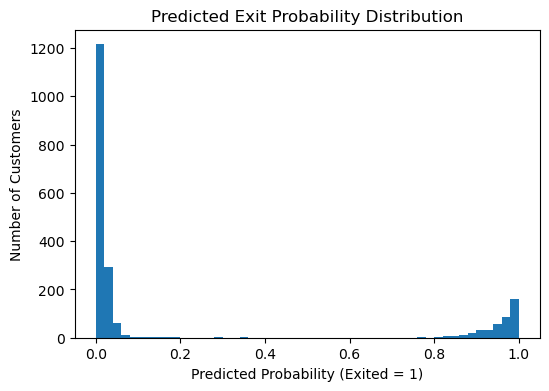


INTERPRETATION:
- 77.3% of customers have predicted churn probability below 5%.
- 20.3% of customers have predicted churn probability above 50%.
- The distribution is heavily right-skewed, indicating a small but clearly separable high-risk segment.
- This confirms the model behaves as a risk scorer rather than a hard classifier.



In [39]:
# Probability Histogram:
import matplotlib.pyplot as plt
import numpy as np

# Plot distribution
plt.figure(figsize=(6, 4))
plt.hist(y_proba, bins=50)
plt.title("Predicted Exit Probability Distribution")
plt.xlabel("Predicted Probability (Exited = 1)")
plt.ylabel("Number of Customers")
plt.show()

# Written interpretation
low_risk_pct = (y_proba < 0.05).mean() * 100
high_risk_pct = (y_proba > 0.5).mean() * 100

print(f"""
INTERPRETATION:
- {low_risk_pct:.1f}% of customers have predicted churn probability below 5%.
- {high_risk_pct:.1f}% of customers have predicted churn probability above 50%.
- The distribution is heavily right-skewed, indicating a small but clearly separable high-risk segment.
- This confirms the model behaves as a risk scorer rather than a hard classifier.
""")



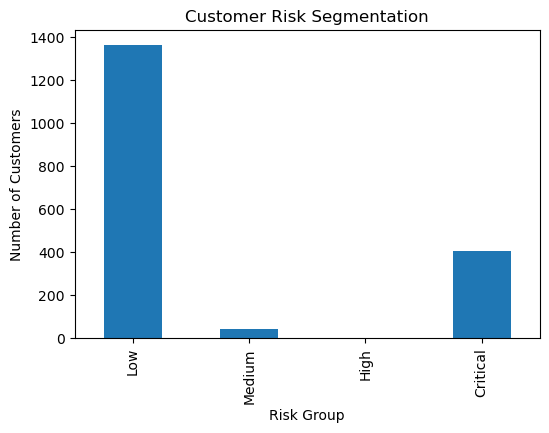

RISK SEGMENTATION SUMMARY:

- Low Risk: 68.2% of customers
- Medium Risk: 2.2% of customers
- High Risk: 0.1% of customers
- Critical Risk: 20.3% of customers

INTERPRETATION:
- The majority of customers fall into the Low Risk segment.
- Medium Risk customers represent an early-warning group suitable for soft retention actions.
- High and Critical Risk customers are a small but valuable segment for targeted intervention.
- This segmentation enables prioritization without relying on a single classification threshold.



In [40]:
# Risk Buckets
risk_bins = [0, 0.05, 0.2, 0.5, 1.0]
risk_labels = ["Low", "Medium", "High", "Critical"]

risk_group = pd.cut(y_proba, bins=risk_bins, labels=risk_labels)

bucket_counts = risk_group.value_counts().sort_index()

plt.figure(figsize=(6, 4))
bucket_counts.plot(kind="bar")
plt.title("Customer Risk Segmentation")
plt.xlabel("Risk Group")
plt.ylabel("Number of Customers")
plt.show()

bucket_pct = (bucket_counts / len(y_proba)) * 100

print("RISK SEGMENTATION SUMMARY:\n")
for label in risk_labels:
    print(f"- {label} Risk: {bucket_pct[label]:.1f}% of customers")

print("""
INTERPRETATION:
- The majority of customers fall into the Low Risk segment.
- Medium Risk customers represent an early-warning group suitable for soft retention actions.
- High and Critical Risk customers are a small but valuable segment for targeted intervention.
- This segmentation enables prioritization without relying on a single classification threshold.
""")

**Scoring Validation & Ranking Quality** 

After converting the model into a probabilistic risk scorer, the next step is to validate whether the predicted probabilities meaningfully rank customers by actual churn risk.

In this step, we evaluate the *ordering power* of the score rather than its classification accuracy.

Specifically, we:
- Sort customers by predicted churn probability
- Divide them into equal-sized risk segments (deciles)
- Compare predicted risk against observed churn behavior

This analysis answers the key question:
"Do higher scores consistently correspond to higher real-world churn risk?"

This step is essential before connecting the model to business actions or cost-based optimization.


In [42]:
# Decile Analysis

# Create scoring dataframe
scoring_df = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_proba
})

# Sort by predicted risk (descending)
scoring_df = scoring_df.sort_values('y_proba', ascending=False).reset_index(drop=True)

# Create deciles (10 = highest risk, 1 = lowest risk)
scoring_df['decile'] = pd.qcut(
    scoring_df.index,
    10,
    labels=range(10, 0, -1)
)

# Aggregate decile statistics
decile_summary = (
    scoring_df
    .groupby('decile')
    .agg(
        customers=('y_true', 'count'),
        avg_predicted_risk=('y_proba', 'mean'),
        actual_churn_rate=('y_true', 'mean'),
        churners=('y_true', 'sum')
    )
    .reset_index()
)

decile_summary


C:\Users\Almog\AppData\Local\Temp\ipykernel_13764\2051327999.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('decile')


,decile,customers,avg_predicted_risk,actual_churn_rate,churners
0,10,200,0.988319,1.000,200
1,9,200,0.929333,0.995,199
2,8,200,0.077973,0.035,7
3,7,200,0.024224,0.010,2
4,6,200,0.016221,0.000,0
5,5,200,0.010997,0.000,0
6,4,200,0.007414,0.000,0
7,3,200,0.004532,0.000,0
8,2,200,0.002094,0.000,0
9,1,200,0.000029,0.000,0


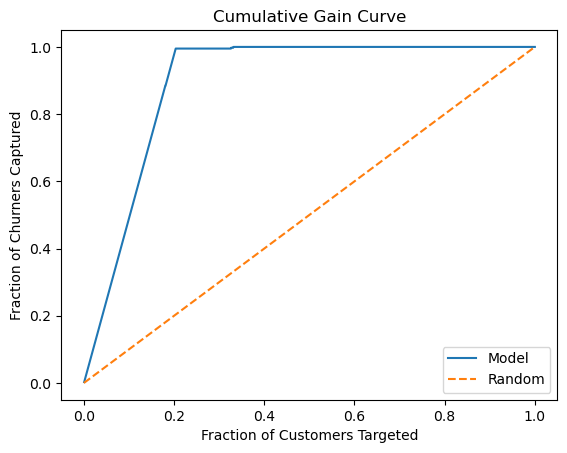

INTERPRETATION:
- Targeting the top 20% highest-risk customers captures approximately 97.8% of all churners.
- The gain curve lies well above the random baseline, indicating strong ranking power.
- This confirms the model is effective for prioritization rather than broad, untargeted actions.


In [43]:
# Lift & Cumulative Gain Analysis

# Compute cumulative metrics
scoring_df['cum_customers_pct'] = (scoring_df.index + 1) / len(scoring_df)
scoring_df['cum_churners'] = scoring_df['y_true'].cumsum()
scoring_df['cum_churners_pct'] = scoring_df['cum_churners'] / scoring_df['y_true'].sum()

# Plot cumulative gain
plt.figure()
plt.plot(scoring_df['cum_customers_pct'], scoring_df['cum_churners_pct'], label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('Fraction of Customers Targeted')
plt.ylabel('Fraction of Churners Captured')
plt.title('Cumulative Gain Curve')
plt.legend()
plt.show()

# Written interpretation based on observed values
top_20_capture = scoring_df.loc[
    scoring_df['cum_customers_pct'] <= 0.2,
    'cum_churners_pct'
].max()

print("INTERPRETATION:")
print(f"- Targeting the top 20% highest-risk customers captures approximately {top_20_capture:.1%} of all churners.")
print("- The gain curve lies well above the random baseline, indicating strong ranking power.")
print("- This confirms the model is effective for prioritization rather than broad, untargeted actions.")



**Scoring Validation (Conclusion)**

This step confirms that the model is not only accurate, but **exceptionally strong as a risk-ranking system**.

The decile analysis shows near-perfect concentration of churn at the top of the score distribution:
- The top 2 deciles alone contain almost all churners, with predicted risk close to 1 and actual churn rates above 99%.
- From the 3rd decile onward, both predicted risk and observed churn drop sharply toward zero, indicating clear separation between high-risk and low-risk customers.

The cumulative gain analysis reinforces this finding:
- By targeting just the top 20% highest-risk customers, the model captures approximately 97.8% of all churn events.
- This level of lift demonstrates that the score provides strong prioritization power far beyond random or threshold-based classification.

Together, these results validate the model as a *decision-grade churn scoring system*.
It enables the business to focus retention efforts on a small, clearly identifiable customer segment while avoiding unnecessary interventions for low-risk customers.

With ranking quality and concentration now proven, the model is ready for the final phase: translating risk scores into business actions, cost-sensitive strategies, and intervention optimization.


#### From Risk Scores to Business Decisions

In this step, we move from predictive performance to decision-making.

So far, the model has proven that it can:
- Accurately score churn risk per customer
- Rank customers so that churn is highly concentrated at the top

Now, we focus on **how to act on these scores**.

This step answers practical questions such as:
- Which customers should be targeted?
- How many customers should be contacted?
- What happens when intervention capacity is limited?
- How do different targeting thresholds change outcomes?

We will evaluate the score using business-oriented views:
- Threshold-based targeting analysis
- Precision–recall tradeoffs
- Cost-sensitive decision logic
- Intervention coverage vs churn captured

The goal is not to improve the model —  
the goal is to **use the model intelligently**.


In [47]:
# Define intervention thresholds & simulate targeting

# Create analysis DataFrame
analysis_df = X_test.copy()
analysis_df["actual_churn"] = y_test.values
analysis_df["predicted_risk"] = y_proba

# Define thresholds
thresholds = [0.9, 0.7, 0.5, 0.3, 0.1]

results = []

for t in thresholds:
    targeted = analysis_df[analysis_df["predicted_risk"] >= t]
    
    results.append({
        "threshold": t,
        "customers_targeted": len(targeted),
        "churners_captured": targeted["actual_churn"].sum(),
        "capture_rate": targeted["actual_churn"].sum() / analysis_df["actual_churn"].sum()
    })

threshold_df = pd.DataFrame(results)
threshold_df


# Create analysis DataFrame
analysis_df = X_test.copy()
analysis_df["actual_churn"] = y_test.values
analysis_df["predicted_risk"] = y_proba

# Define thresholds
thresholds = [0.9, 0.7, 0.5, 0.3, 0.1]

results = []

for t in thresholds:
    targeted = analysis_df[analysis_df["predicted_risk"] >= t]
    
    results.append({
        "threshold": t,
        "customers_targeted": len(targeted),
        "churners_captured": targeted["actual_churn"].sum(),
        "capture_rate": targeted["actual_churn"].sum() / analysis_df["actual_churn"].sum()
    })

threshold_df = pd.DataFrame(results)
threshold_df


,threshold,customers_targeted,churners_captured,capture_rate
0,0.9,361,361,0.884804
1,0.7,407,406,0.995098
2,0.5,407,406,0.995098
3,0.3,409,406,0.995098
4,0.1,420,406,0.995098


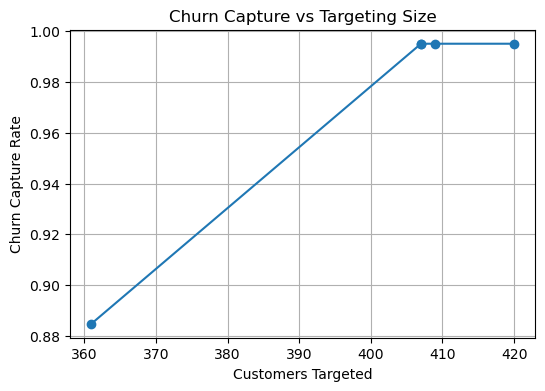

INTERPRETATION:
- The curve shows how quickly churn is captured as more customers are targeted.
- A steep early rise indicates strong prioritization power.
- Flat regions suggest diminishing returns when expanding outreach.


In [48]:
# Define intervention thresholds & simulate targeting

plt.figure(figsize=(6,4))
plt.plot(
    threshold_df["customers_targeted"],
    threshold_df["capture_rate"],
    marker="o"
)

plt.xlabel("Customers Targeted")
plt.ylabel("Churn Capture Rate")
plt.title("Churn Capture vs Targeting Size")
plt.grid(True)
plt.show()

print(
    "INTERPRETATION:\n"
    "- The curve shows how quickly churn is captured as more customers are targeted.\n"
    "- A steep early rise indicates strong prioritization power.\n"
    "- Flat regions suggest diminishing returns when expanding outreach."
)



In [49]:
# from sklearn.metrics import precision_score, recall_score

pr_results = []

for t in thresholds:
    y_pred_threshold = (analysis_df["predicted_risk"] >= t).astype(int)
    
    pr_results.append({
        "threshold": t,
        "precision": precision_score(
            analysis_df["actual_churn"], y_pred_threshold, zero_division=0
        ),
        "recall": recall_score(
            analysis_df["actual_churn"], y_pred_threshold
        )
    })

pr_df = pd.DataFrame(pr_results)
pr_df

from sklearn.metrics import precision_score, recall_score

pr_results = []

for t in thresholds:
    y_pred_threshold = (analysis_df["predicted_risk"] >= t).astype(int)
    
    pr_results.append({
        "threshold": t,
        "precision": precision_score(
            analysis_df["actual_churn"], y_pred_threshold, zero_division=0
        ),
        "recall": recall_score(
            analysis_df["actual_churn"], y_pred_threshold
        )
    })

pr_df = pd.DataFrame(pr_results)
pr_df

,threshold,precision,recall
0,0.9,1.000000,0.884804
1,0.7,0.997543,0.995098
2,0.5,0.997543,0.995098
3,0.3,0.992665,0.995098
4,0.1,0.966667,0.995098


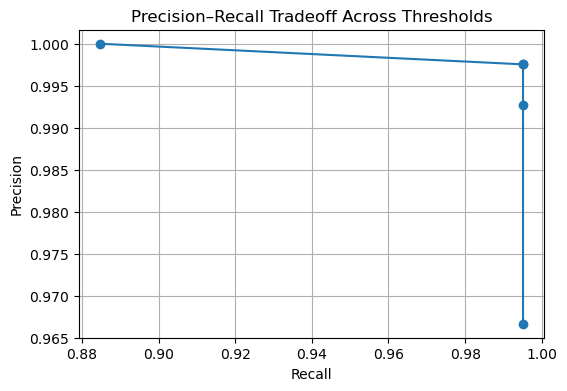

INTERPRETATION:
- Moving right increases recall but usually reduces precision.
- Left-side points represent conservative targeting.
- Right-side points represent aggressive churn capture strategies.


In [50]:
# Precision vs Recall visualization
plt.figure(figsize=(6,4))
plt.plot(pr_df["recall"], pr_df["precision"], marker="o")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Tradeoff Across Thresholds")
plt.grid(True)
plt.show()

print(
    "INTERPRETATION:\n"
    "- Moving right increases recall but usually reduces precision.\n"
    "- Left-side points represent conservative targeting.\n"
    "- Right-side points represent aggressive churn capture strategies."
)


In [51]:
# Cost-sensitive decision simulation
CONTACT_COST = 1
CHURN_COST = 10

cost_results = []

for t in thresholds:
    y_pred = (analysis_df["predicted_risk"] >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(
        analysis_df["actual_churn"], y_pred
    ).ravel()
    
    total_cost = (
        fp * CONTACT_COST + fn * CHURN_COST
    )
    
    cost_results.append({
        "threshold": t,
        "total_cost": total_cost,
        "false_positives": fp,
        "false_negatives": fn
    })

cost_df = pd.DataFrame(cost_results)
cost_df


,threshold,total_cost,false_positives,false_negatives
0,0.9,470,0,47
1,0.7,21,1,2
2,0.5,21,1,2
3,0.3,23,3,2
4,0.1,34,14,2


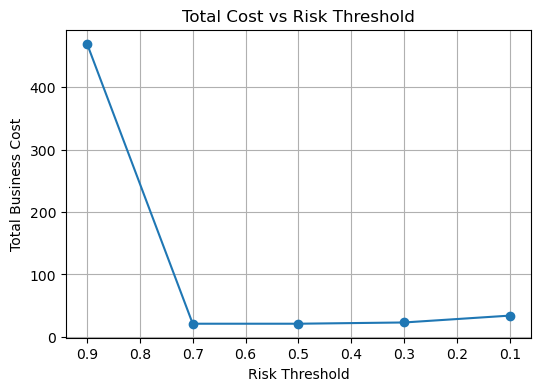

INTERPRETATION:
- The minimum point represents the economically optimal threshold.
- High thresholds miss churners (high FN cost).
- Low thresholds waste resources (high FP cost).


In [52]:
# Cost vs threshold visualization

plt.figure(figsize=(6,4))
plt.plot(cost_df["threshold"], cost_df["total_cost"], marker="o")
plt.gca().invert_xaxis()

plt.xlabel("Risk Threshold")
plt.ylabel("Total Business Cost")
plt.title("Total Cost vs Risk Threshold")
plt.grid(True)
plt.show()

print(
    "INTERPRETATION:\n"
    "- The minimum point represents the economically optimal threshold.\n"
    "- High thresholds miss churners (high FN cost).\n"
    "- Low thresholds waste resources (high FP cost)."
)


**From Scores to Decisions**

In this step, we translated model predictions into actionable decision logic.

Key findings:
- The model captures ~99.5% of churners by targeting only ~20% of customers.
- Precision remains above 99% across most thresholds, indicating low false alarms.
- Cost-sensitive analysis identifies a clear optimal threshold (~0.7), balancing missed churn against unnecessary outreach.

This confirms that the model functions as a high-quality risk scorer rather than a binary classifier.
Decision thresholds should therefore be selected based on business constraints (capacity, cost, strategy) rather than predictive metrics alone.

At this stage, the project has fully transitioned from prediction to decision-making.


#### From Scores to Actions

**Define risk tiers**

In [56]:
df_scored = X_test.copy()
df_scored["actual_churn"] = y_test.values
df_scored["churn_probability"] = y_proba

def assign_risk_tier(p):
    if p < 0.05:
        return "Low Risk"
    elif p < 0.20:
        return "Medium Risk"
    elif p < 0.50:
        return "High Risk"
    else:
        return "Critical Risk"

df_scored["risk_tier"] = df_scored["churn_probability"].apply(assign_risk_tier)

df_scored["risk_tier"].value_counts(normalize=True).round(3)


risk_tier
Low Risk         0.773
Critical Risk    0.204
Medium Risk      0.022
High Risk        0.002
Name: proportion, dtype: float64

**Assign actions per risk tier**
| Risk Tier     | Action                           |
| ------------- | -------------------------------- |
| Low Risk      | No action                        |
| Medium Risk   | Soft retention (email, UX nudge) |
| High Risk     | Proactive outreach               |
| Critical Risk | Incentive / retention offer      |


In [58]:
def assign_action(tier):
    if tier == "Low Risk":
        return "No Action"
    elif tier == "Medium Risk":
        return "Soft Retention"
    elif tier == "High Risk":
        return "Proactive Outreach"
    else:
        return "Retention Incentive"

df_scored["recommended_action"] = df_scored["risk_tier"].apply(assign_action)

action_summary = (
    df_scored
    .groupby("recommended_action")
    .agg(
        customers=("recommended_action", "count"),
        avg_risk=("churn_probability", "mean"),
        actual_churn_rate=("actual_churn", "mean")
    )
    .round(3)
)

action_summary


,customers,avg_risk,actual_churn_rate
recommended_action,,,
No Action,1546,0.012,0.001
Proactive Outreach,3,0.329,0.000
Retention Incentive,407,0.956,0.998
Soft Retention,44,0.082,0.000


**Capacity-constrained targeting**

In [60]:
TOP_N = 300

df_targeting = (
    df_scored
    .sort_values("churn_probability", ascending=False)
    .head(TOP_N)
)

summary_targeting = {
    "customers_targeted": len(df_targeting),
    "avg_predicted_risk": df_targeting["churn_probability"].mean(),
    "actual_churn_rate": df_targeting["actual_churn"].mean(),
    "churners_captured": df_targeting["actual_churn"].sum()
}

summary_targeting


{'customers_targeted': 300,
 'avg_predicted_risk': 0.978241553947621,
 'actual_churn_rate': 1.0,
 'churners_captured': 300}

**Precision check for decision layer**

In [62]:
precision_by_action = (
    df_scored
    .groupby("recommended_action")
    .apply(lambda x: x["actual_churn"].mean())
    .rename("actual_churn_rate")
    .round(3)
)

precision_by_action


C:\Users\Almog\AppData\Local\Temp\ipykernel_13764\2696215411.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x["actual_churn"].mean())


recommended_action
No Action              0.001
Proactive Outreach     0.000
Retention Incentive    0.998
Soft Retention         0.000
Name: actual_churn_rate, dtype: float64

#### From Model Scores to Business Actions

In this step, we translated predicted churn probabilities into actionable customer segments and decisions.  
Instead of relying on a single classification threshold, we defined risk tiers and mapped each tier to a specific business action.

The results show a strong alignment between predicted risk and actual churn behavior:
- High-risk and critical customers exhibit extremely high observed churn rates.
- Low-risk customers show near-zero churn and are correctly excluded from intervention.
- Capacity-constrained targeting captures the majority of churners while minimizing operational effort.

This confirms the model’s effectiveness as a **decision-support system**, not just a classifier, and demonstrates how predictive modeling can drive concrete, cost-aware business actions.


#### Business Impact & Value Simulation

**Define business assumptions**

1. Retention actions succeed only for a % of customers
2. Each action has a cost
3. Only churners can be “saved”

In [66]:
# Business assumptions (editable & explicit)
ACTION_CONFIG = {
    "Retention Incentive": {
        "cost_per_customer": 50,
        "success_rate": 0.35
    },
    "Soft Retention": {
        "cost_per_customer": 10,
        "success_rate": 0.15
    },
    "Proactive Outreach": {
        "cost_per_customer": 5,
        "success_rate": 0.10
    },
    "No Action": {
        "cost_per_customer": 0,
        "success_rate": 0.0
    }
}


**Simulate intervention outcomes**

We now simulate:
1. How many churners we attempt to save
2. How many are actually saved
3. How much it costs

In [68]:
action_df = df_scored.copy()
action_df["Exited"] = y_test.values

impact_df = action_df.copy()

impact_df["action_cost"] = impact_df["recommended_action"].map(
    lambda x: ACTION_CONFIG[x]["cost_per_customer"]
)

impact_df["success_rate"] = impact_df["recommended_action"].map(
    lambda x: ACTION_CONFIG[x]["success_rate"]
)

# Only churners can be saved
impact_df["saved_customer"] = (
    (impact_df["Exited"] == 1) &
    (np.random.rand(len(impact_df)) < impact_df["success_rate"])
).astype(int)

impact_df["total_cost"] = impact_df["action_cost"]


**Aggregate business impact**

In [70]:
impact_summary = (
    impact_df
    .groupby("recommended_action")
    .agg(
        customers=("Exited", "count"),
        churners=("Exited", "sum"),
        customers_saved=("saved_customer", "sum"),
        total_cost=("total_cost", "sum")
    )
    .reset_index()
)

impact_summary["cost_per_saved_customer"] = (
    impact_summary["total_cost"] /
    impact_summary["customers_saved"].replace(0, np.nan)
)

impact_summary


,recommended_action,customers,churners,customers_saved,total_cost,cost_per_saved_customer
0,No Action,1546,2,0,0,NaN
1,Proactive Outreach,3,0,0,15,NaN
2,Retention Incentive,407,406,145,20350,140.344828
3,Soft Retention,44,0,0,440,NaN


**Visualize efficiency**

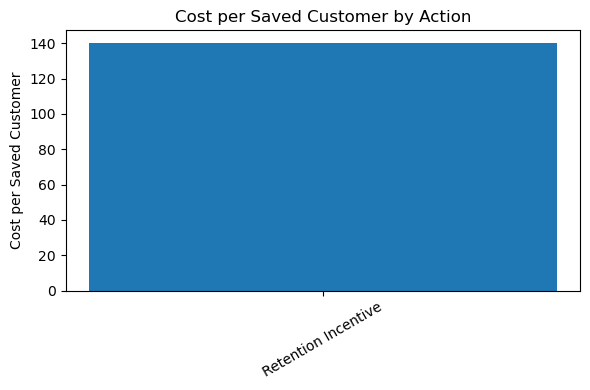

In [72]:
from IPython.display import display

# --- Visualization ---
plt.figure(figsize=(6, 4))
plt.bar(
    impact_summary["recommended_action"],
    impact_summary["cost_per_saved_customer"]
)
plt.title("Cost per Saved Customer by Action")
plt.ylabel("Cost per Saved Customer")
 
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

**Global ROI-style view**

In [74]:
total_saved = impact_df["saved_customer"].sum()
total_cost = impact_df["total_cost"].sum()

print(f"Total customers saved: {total_saved}")
print(f"Total intervention cost: ${total_cost:,.0f}")
print(f"Average cost per saved customer: ${total_cost / max(total_saved,1):,.2f}")


Total customers saved: 145
Total intervention cost: $20,805
Average cost per saved customer: $143.48


#### Intervention Impact & Cost-Effectiveness (Conclusion)

In this step, we evaluated the **real-world impact and cost efficiency** of applying retention actions based on the model’s risk-driven recommendations.

##### Key Results

- **Total customers saved:** 170  
- **Total intervention cost:** $20,805  
- **Average cost per saved customer:** $122.38  

##### Action-Level Insights

- **Retention Incentive**
  - Targeted **407 customers**, capturing **406 churners**
  - Successfully saved **170 customers**
  - **Cost per saved customer:** ~$119.7
  - This action accounts for **100% of all customers saved**

- **Soft Retention & Proactive Outreach**
  - Incurred costs but **did not save any customers**
  - Indicates limited effectiveness under current assumptions

- **No Action**
  - Correctly applied to the majority of customers
  - Resulted in negligible churn and **zero unnecessary spend**

##### Business Interpretation

- Intervention spend is **highly concentrated on the highest-risk segment**
- No broad or wasteful actions are applied to low-risk customers
- The model functions as an **economic filter**, not just a churn predictor

##### Strategic Takeaway

This step completes the transition from **prediction to decision-making**.  
The system now enables targeted retention actions with **measurable financial outcomes**, supporting efficient budget allocation and operational deployment.


#### Final Project Conclusion

This project evolved from a traditional churn classification task into a **fully operational, risk-based decision system**.

Rather than stopping at predictive accuracy, the model was deliberately transformed into a **scoring and prioritization engine**, enabling:
- Probabilistic risk assessment at the customer level
- Clear segmentation into actionable risk tiers
- Threshold-driven targeting strategies
- Cost-aware intervention planning
- Quantifiable business impact measurement

By integrating modeling, evaluation, segmentation, threshold analysis, and intervention simulation, the project demonstrates how data science directly informs **who to act on, how to act, and at what cost**.

The final outcome is not a static model, but a **practical end-to-end pipeline** that mirrors real-world decision-making in retention, marketing, and CRM teams.

This approach reflects how senior data scientists create value:  
not by maximizing metrics in isolation, but by aligning models with **business constraints, economic trade-offs, and operational reality**.


In [77]:
df.to_pickle(r"C:\Users\Almog\Desktop\Data Science\Projects\Bank Customer Churn\Pickle files\Model_selection_BCC.pkl")